In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [8]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  Remove all schools that have no IDACI rating
#df = df[pd.notnull(df['IDACI'])]

# Remove schools with low Entries
#df = df[(df.filter(regex='Entries')>10).all(axis=1)]

# Remove schools with high exam_score
#df = df[(df.filter(like='exam_score|2013_')<0.7).all(axis=1)]

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Remove any unecessary features
#df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)


# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['student_activity']].quantile(0.95)
df_out = df[(df[q.keys()] < q).all(axis=1)]

print(df_out.shape)
df_out.head()


(854, 87)


,Entries|2013_Biology,Entries|2013_Chemistry,Entries|2013_Mathematics,Entries|2013_Physics,Entries|2014_Biology,Entries|2014_Chemistry,Entries|2014_Mathematics,Entries|2014_Physics,Entries|2015_Biology,Entries|2015_Chemistry,...,play_video_std,exam_improv_2013-2014_Biology,exam_improv_2013-2014_Mathematics,exam_improv_2013-2014_Chemistry,exam_improv_2013-2014_Physics,exam_improv_2013-2016_Biology,exam_improv_2013-2016_Mathematics,exam_improv_2013-2016_Chemistry,exam_improv_2013-2016_Physics,student_activity
URN,,,,,,,,,,,,,,,,,,,,,
100001,19.0,25.0,53.0,17.0,16.0,20.0,41.0,17.0,15.0,14.0,...,41.0,0.036272,-0.003697,-0.061495,-0.099692,0.029736,-0.043330,-0.003100,-0.062738,16.300000
100003,24.0,35.0,77.0,41.0,39.0,37.0,88.0,34.0,26.0,45.0,...,192.0,-0.080350,-0.020661,-0.019674,0.052747,-0.020112,-0.013455,-0.009502,0.106763,72.774194
100054,32.0,21.0,75.0,29.0,34.0,35.0,69.0,21.0,42.0,28.0,...,438.0,0.138762,-0.006687,0.016362,0.015041,-0.035131,-0.017300,0.003301,-0.038957,17.307692
100065,33.0,35.0,70.0,28.0,30.0,34.0,67.0,31.0,25.0,29.0,...,485.0,0.096233,0.001924,0.015242,0.059983,0.064762,-0.037641,0.037853,0.113732,72.114286
100076,10.0,14.0,27.0,11.0,18.0,21.0,32.0,12.0,22.0,20.0,...,1.0,-0.107807,0.032783,-0.044749,-0.167057,-0.109535,-0.023395,-0.024589,-0.062783,1.714286


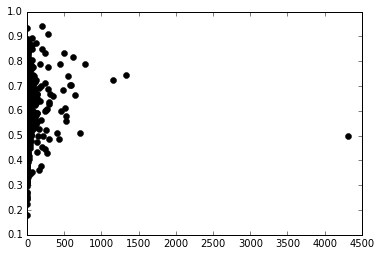

In [11]:
plt.plot(df['student_activity'],df['exam_score|2016_Physics'],'ok')

In [66]:
def test_correlation(df, x_array, y_array, corrType):
    
    store_array = []
    
    for item_x in x_array:
        for item_y in y_array:
            score, pval = corrType(df[item_x],df[item_y])
            store_array.append([item_x, item_y, score,pval])
            
    df = pd.DataFrame(store_array,columns=['x','y','Correlation','P Value'])
            
    return df

# No outliers
print('Pearson Correlation')
print(test_correlation(df_out, ['student_activity'], df_out.filter(regex='exam_improv').columns, pearsonr).sort_values('P Value'))

print('\nSpearman Correlation')
print(test_correlation(df_out, ['student_activity'], df_out.filter(regex='exam_improv').columns, spearmanr).sort_values('P Value'))

print('\nKendall Correlation')
print(test_correlation(df_out, ['student_activity'], df_out.filter(regex='exam_improv').columns, kendalltau).sort_values('P Value'))

Pearson Correlation
                  x                                  y  Correlation   P Value
7  student_activity      exam_improv_2013-2016_Physics     0.087178  0.010811
6  student_activity    exam_improv_2013-2016_Chemistry     0.049250  0.150432
5  student_activity  exam_improv_2013-2016_Mathematics     0.028214  0.410238
4  student_activity      exam_improv_2013-2016_Biology     0.022045  0.519989
2  student_activity    exam_improv_2013-2014_Chemistry    -0.014951  0.662625
1  student_activity  exam_improv_2013-2014_Mathematics    -0.013563  0.692263
0  student_activity      exam_improv_2013-2014_Biology    -0.006572  0.847921
3  student_activity      exam_improv_2013-2014_Physics    -0.000597  0.986091

Spearman Correlation
                  x                                  y  Correlation   P Value
7  student_activity      exam_improv_2013-2016_Physics     0.081816  0.016782
6  student_activity    exam_improv_2013-2016_Chemistry     0.080674  0.018376
5  student_activity  e

,Coef,R^2,X,Y,intercept
2,-0.000046,2.235228e-04,student_activity,exam_improv_2013-2014_Chemistry,0.002622
1,-0.000036,1.839487e-04,student_activity,exam_improv_2013-2014_Mathematics,0.006206
0,-0.000020,4.318934e-05,student_activity,exam_improv_2013-2014_Biology,0.005284
3,-0.000002,3.569044e-07,student_activity,exam_improv_2013-2014_Physics,-0.004720
4,0.000072,4.859838e-04,student_activity,exam_improv_2013-2016_Biology,-0.000302
5,0.000077,7.960548e-04,student_activity,exam_improv_2013-2016_Mathematics,-0.019327
6,0.000167,2.425549e-03,student_activity,exam_improv_2013-2016_Chemistry,-0.011228
7,0.000357,7.600045e-03,student_activity,exam_improv_2013-2016_Physics,-0.013774


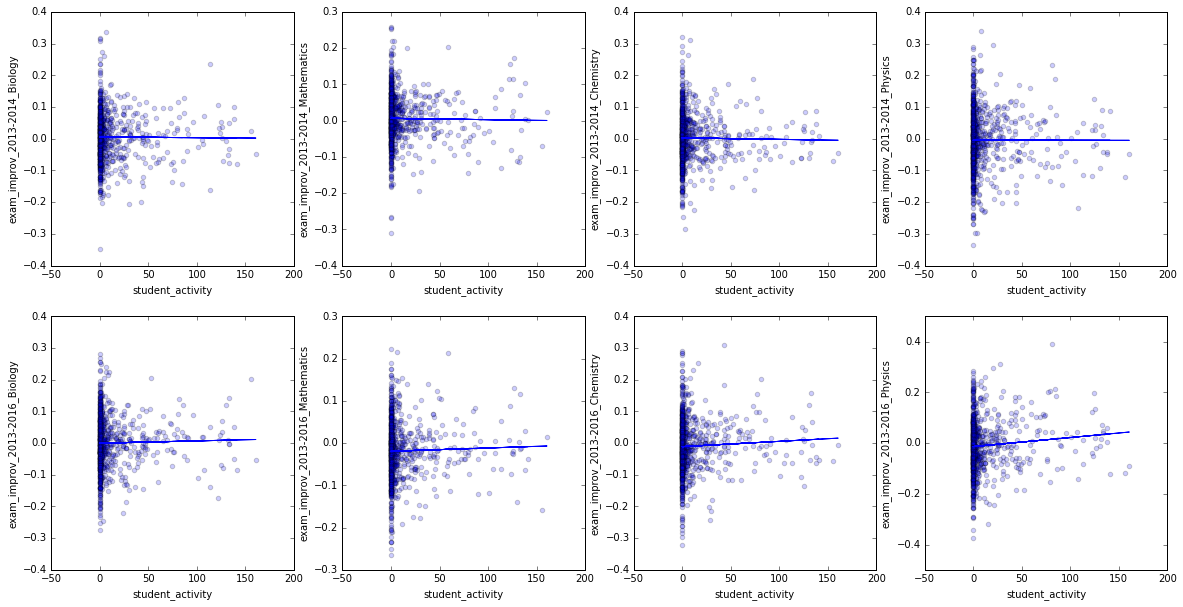

In [67]:
# Let's do a plot 

df_score = checkLinearFit(df_out,['student_activity'],df_out.filter(like='exam_improv').columns, n_cols=4, n_rows=2,figsize=(20,10))

df_score.sort_values('Coef')

In [69]:
# There seems to be a noticeable difference for Physics, let's do a t-test

ttest_ind(df_out['exam_improv_2013-2014_Physics'],df_out['exam_improv_2013-2016_Physics'],equal_var=True)


Ttest_indResult(statistic=0.99677147084381534, pvalue=0.31901680489051559)

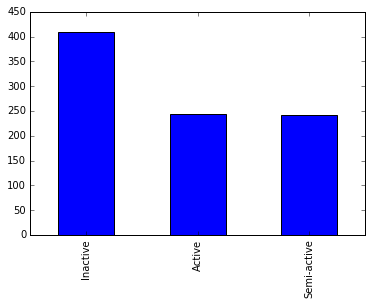

In [110]:
# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories


# ------------------------------------------------------
# Choose a feature and determine distribution
# ------------------------------------------------------

bins = [-0.1, 0, 10,1000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')

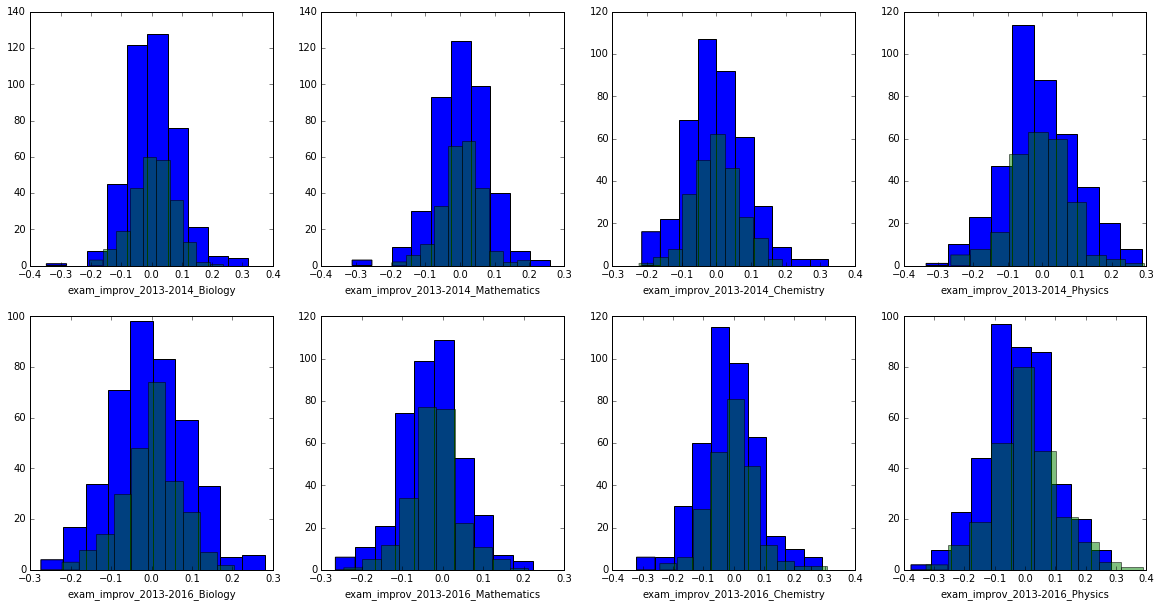

In [111]:
# Create a general function

def plotHistograms(feature_list,nrows, ncols, figsize=(20,10)):
    
    
    plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize);

    count = 1;
    for feature in feature_list:
        
        plt.subplot(nrows,ncols,count)
        plt.hist(df[df['categories']=='Inactive'][feature])
        plt.hist(df[df['categories']=='Active'][feature],alpha=0.5)
        plt.xlabel(feature)
        count += 1
    
plotHistograms(df.filter(regex='exam_improv').columns,2,4)

In [115]:
# Doing an F-test on all variables of interest

from sklearn.feature_selection import f_classif


df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
F, pval = f_classif(X, y)

df_score = pd.DataFrame({'Key':X.keys(),'F score':F,'p values':pval})

df_score.sort_values('p values')


,F score,Key,p values
7,3.793757,exam_improv_2013-2016_Physics,0.051871
6,3.378070,exam_improv_2013-2016_Chemistry,0.066522
5,1.013199,exam_improv_2013-2016_Mathematics,0.314509
4,0.390232,exam_improv_2013-2016_Biology,0.532395
3,0.045029,exam_improv_2013-2014_Physics,0.832017
2,0.026878,exam_improv_2013-2014_Chemistry,0.869824
0,0.009888,exam_improv_2013-2014_Biology,0.920821
1,0.005351,exam_improv_2013-2014_Mathematics,0.941710
